In [1]:
# Name: Zhonghao Liu

In [2]:
! hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [3]:
! hdfs dfs -ls hdfs://nn:9000/

Found 22 items
-rw-r--r--   1 root supergroup        328 2023-11-09 18:22 hdfs://nn:9000/action_taken.csv
-rw-r--r--   1 root supergroup        317 2023-11-09 18:22 hdfs://nn:9000/agency.csv
-rw-r--r--   1 root supergroup     533472 2023-11-09 18:22 hdfs://nn:9000/arid2017_to_lei_xref_csv.csv
-rw-r--r--   1 root supergroup     319092 2023-11-09 18:22 hdfs://nn:9000/counties.csv
-rw-r--r--   1 root supergroup        237 2023-11-09 18:22 hdfs://nn:9000/denial_reason.csv
-rw-r--r--   1 root supergroup        109 2023-11-09 18:22 hdfs://nn:9000/edit_status.csv
-rw-r--r--   1 root supergroup        180 2023-11-09 18:22 hdfs://nn:9000/ethnicity.csv
-rw-r--r--   1 root supergroup  174944099 2023-11-09 18:22 hdfs://nn:9000/hdma-wi-2021.csv
-rw-r--r--   1 root supergroup         41 2023-11-09 18:22 hdfs://nn:9000/hoepa.csv
-rw-r--r--   1 root supergroup        114 2023-11-09 18:22 hdfs://nn:9000/lien_status.csv
-rw-r--r--   1 root supergroup         65 2023-11-09 18:22 hdfs://nn:9000/loan_purpo

In [4]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/09 18:23:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Part 1

### Q1: how many banks contain the word "first" in their name, ignoring case? Use an RDD to answer.

In [5]:
# TODO: modify to treat the first row as a header
# TODO: modify to infer the schema
banks_df = (spark.read.format("csv")
            .option("header", True)
            .option("inferSchema", True)
            .load("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv"))

In [6]:
rows = banks_df.rdd.take(3)
rows[0]['respondent_name']

'First National Bank'

In [7]:
#q1
banks_df.rdd.filter(lambda x: ("first" in x['respondent_name'].lower())).count()

525

### Q2: how many banks contain the word "first" in their name, ignoring case? Use a DataFrame to answer.

In [8]:
#q2

# References:
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.filter.html
# https://www.w3schools.com/sql/sql_like.asp
# https://www.w3schools.com/sql/func_sqlserver_lower.asp

from pyspark.sql.functions import expr, col
banks_df.select(col("respondent_name")).filter("LOWER(respondent_name) LIKE '%first%'").count()

525

### Q3: how many banks contain the word "first" in their name, ignoring case? Use Spark SQL to answer.

In [9]:
#q3
banks_df.write.saveAsTable("banks", mode="overwrite")
spark.sql("SELECT COUNT(*) FROM banks WHERE LOWER(respondent_name) LIKE '%first%'").toPandas()['count(1)'][0]

23/11/09 18:23:49 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/09 18:23:49 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/09 18:23:53 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/09 18:23:53 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.20.0.2
23/11/09 18:23:54 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/11/09 18:23:59 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/11/09 18:23:59 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/11/09 18:23:59 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/09 18:23:59 W

525

# Part 2

### Q4: what tables are in our warehouse?

In [10]:
# spark.catalog.dropTempView("banks")

In [11]:
spark.sql("SHOW TABLES").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|  default|    banks|      false|
|  default|    loans|      false|
+---------+---------+-----------+



In [12]:
loans_df = (spark.read.format("csv")
            .option("header", True)
            .option("inferSchema", True)
            .load("hdfs://nn:9000/hdma-wi-2021.csv"))

In [13]:
# Reference:
# https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.DataFrameWriter.bucketBy.html

(loans_df.write.format('parquet')  
    .bucketBy(8, 'county_code')
    .mode("overwrite")
    .saveAsTable('loans'))

23/11/09 18:24:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [14]:
spark.sql("SHOW TABLES").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|  default|    banks|      false|
|  default|    loans|      false|
+---------+---------+-----------+



In [15]:
views = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken", "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]
for v in views:
    (spark.read.format("csv")
        .option("header", True)
        .option("inferSchema", True)
        .load(f"hdfs://nn:9000/{v}.csv").createOrReplaceTempView(v))

In [16]:
#q4

tables = spark.sql("SHOW TABLES").toPandas()
dict = {}
for i in range(len(tables)):
    curr_table = tables['tableName'][i]
    curr_temp = tables['isTemporary'][i]
    dict[curr_table] = curr_temp
dict

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

### Q5: how many loan applications has the bank "University of Wisconsin Credit Union" received in 2020 in this dataset?

In [17]:
spark.sql("SELECT * FROM banks LIMIT 3").toPandas()

,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,First National Bank,110004,5493003EW6T31TGECO83,5493003EW6T31TGECO83,5493003EW6T31TGECO83
1,"First Mid Bank & Trust, National Association",110045,549300XOTES5TCS8T794,549300XOTES5TCS8T794,549300XOTES5TCS8T794
2,"First Hope Bank, A National Banking Association",110118,5493003XLOX5FDT9R120,5493003XLOX5FDT9R120,5493003XLOX5FDT9R120


In [18]:
#q5

spark.sql("""
SELECT COUNT(*) FROM banks
INNER JOIN loans ON banks.lei_2020 = loans.lei
WHERE respondent_name = 'University of Wisconsin Credit Union'
""").toPandas()['count(1)'][0]

19739

In [19]:
#q6

spark.sql("""
SELECT COUNT(*) FROM banks
INNER JOIN loans ON banks.lei_2020 = loans.lei
WHERE respondent_name = 'University of Wisconsin Credit Union'
""").explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (12)
+- HashAggregate (11)
   +- Exchange (10)
      +- HashAggregate (9)
         +- Project (8)
            +- BroadcastHashJoin Inner BuildLeft (7)
               :- BroadcastExchange (4)
               :  +- Project (3)
               :     +- Filter (2)
               :        +- Scan parquet spark_catalog.default.banks (1)
               +- Filter (6)
                  +- Scan parquet spark_catalog.default.loans (5)


(1) Scan parquet spark_catalog.default.banks
Output [2]: [respondent_name#62, lei_2020#66]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2020:string>

(2) Filter
Input [2]: [respondent_name#62, lei_2020#66]
Condition : ((isnotnull(respondent_name#62) AND (respondent_name#62 = University of Wisconsin Credit Union)) AND i

### Q6 explanations
### 1. Which table is sent to every executor via a `BroadcastExchange` operation?
For the sole `(4) BroadcastExchange`, since its input as well as its output reflected in `(3) Project` involves the `lei_2020` column, the `loans` table is sent.
### 2. Does the plan involve `HashAggregate`s (depending on how you write the query, it may or may not)? If so, which ones?
Two `HashAggregate`s are involved. For `(11)` it is a regular count referring to the `COUNT(*)` at the first line of query. For `(9)`it is a partial count. Based on the following operations `(8)` and `(7)`, `(9)` is involved in the `INNER JOIN` at the second line of query.

# Part 3

### Q7: what are the average interest rates for Wells Fargo applications for the ten counties where Wells Fargo receives the most applications?

In [20]:
spark.sql("SELECT * FROM banks LIMIT 3").toPandas().columns.values

array(['respondent_name', 'arid_2017', 'lei_2018', 'lei_2019', 'lei_2020'],
      dtype=object)

In [21]:
spark.sql("SELECT * FROM loans LIMIT 3").toPandas().columns.values

array(['activity_year', 'lei', 'derived_msa-md', 'state_code',
       'county_code', 'census_tract', 'conforming_loan_limit',
       'derived_loan_product_type', 'derived_dwelling_category',
       'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken',
       'purchaser_type', 'preapproval', 'loan_type', 'loan_purpose',
       'lien_status', 'reverse_mortgage', 'open-end_line_of_credit',
       'business_or_commercial_purpose', 'loan_amount',
       'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'total_points_and_fees',
       'origination_charges', 'discount_points', 'lender_credits',
       'loan_term', 'prepayment_penalty_term', 'intro_rate_period',
       'negative_amortization', 'interest_only_payment',
       'balloon_payment', 'other_nonamortizing_features',
       'property_value', 'construction_method', 'occupancy_type',
       'manufactured_home_secured_property_type',
       'manufactured_home_land_property_inte

In [22]:
spark.sql("SELECT * FROM counties LIMIT 1").toPandas()

,AREA,PERIMETER,CO99_D00_,CO99_D00_I,STATE,COUNTY,NAME,LSAD,LSAD_TRANS
0,52.91341,60.56496,2.0,1.0,2,185,North Slope,4,Borough


In [23]:
topten = spark.sql("""
SELECT NAME, COUNT(*) AS count, AVG(interest_rate) AS avg_rate
FROM (
    SELECT county_code, interest_rate FROM loans
    INNER JOIN banks ON loans.lei = banks.lei_2020
    WHERE respondent_name LIKE "Wells Fargo%"
) AS new_table
INNER JOIN counties ON new_table.county_code = counties.STATE*1000 + counties.COUNTY
GROUP BY counties.NAME
ORDER BY count DESC
LIMIT 10
""").toPandas()

In [24]:
topten

,NAME,count,avg_rate
0,Milwaukee,2164,3.117347
1,Waukesha,1832,2.875823
2,Washington,748,2.851009
3,Dane,729,2.890675
4,Brown,663,3.010949
5,Racine,537,3.099784
6,Outagamie,513,2.979662
7,Winnebago,402,3.028476
8,Ozaukee,389,2.867377
9,Sheboygan,307,2.995511


In [25]:
#q7
dict = {}
for i in range(len(topten['NAME'])):
    dict[topten['NAME'][i]] = topten['avg_rate'][i]
dict

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

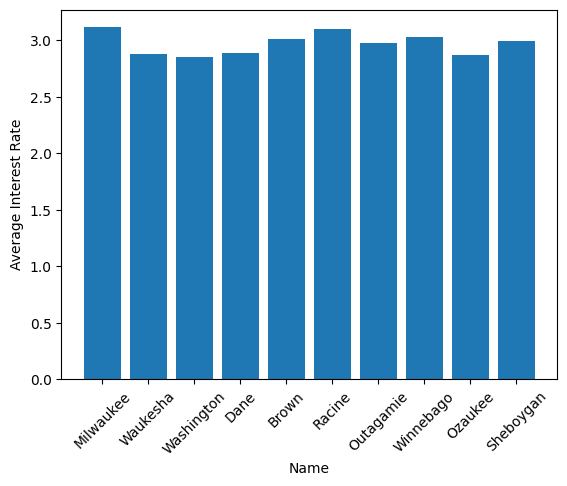

In [26]:
# create bar chart
# References: 
# https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary
# https://stackoverflow.com/questions/47447220/how-to-label-x-axis-using-python-matplotlib
# https://www.geeksforgeeks.org/how-to-rotate-x-axis-tick-label-text-in-matplotlib/#

import matplotlib.pyplot as plt

plt.bar(*zip(*dict.items()))
plt.xlabel('Name')
plt.ylabel('Average Interest Rate')
plt.xticks(rotation = 45)
plt.show()

### Q8: when computing a MEAN aggregate per group of loans, under what situation (when) do we require network I/O between the partial_mean and mean operations?

In [27]:
spark.sql("""
SELECT lei, MEAN(income)
FROM loans
GROUP BY lei
""").explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (5)
+- HashAggregate (4)
   +- Exchange (3)
      +- HashAggregate (2)
         +- Scan parquet spark_catalog.default.loans (1)


(1) Scan parquet spark_catalog.default.loans
Output [2]: [lei#1048, income#1092]
Batched: true
Bucketed: false (bucket column(s) not read)
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
ReadSchema: struct<lei:string,income:string>

(2) HashAggregate
Input [2]: [lei#1048, income#1092]
Keys [1]: [lei#1048]
Functions [1]: [partial_mean(cast(income#1092 as double))]
Aggregate Attributes [2]: [sum#1304, count#1305L]
Results [3]: [lei#1048, sum#1306, count#1307L]

(3) Exchange
Input [3]: [lei#1048, sum#1306, count#1307L]
Arguments: hashpartitioning(lei#1048, 200), ENSURE_REQUIREMENTS, [plan_id=966]

(4) HashAggregate
Input [3]: [lei#1048, sum#1306, count#1307L]
Keys [1]: [lei#1048]
Functions [1]: [mean(cast(income#1092 as double))]
Aggregate Attributes [1]: [mean(cast(income#1092 as double))#1300]
Resul

In [28]:
spark.sql("""
SELECT county_code, MEAN(income)
FROM loans
GROUP BY county_code
""").explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet spark_catalog.default.loans (1)


(1) Scan parquet spark_catalog.default.loans
Output [2]: [county_code#1051, income#1092]
Batched: true
Bucketed: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,income:string>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [2]: [county_code#1051, income#1092]
Keys [1]: [county_code#1051]
Functions [1]: [partial_mean(cast(income#1092 as double))]
Aggregate Attributes [2]: [sum#1312, count#1313L]
Results [3]: [county_code#1051, sum#1314, count#1315L]

(3) HashAggregate
Input [3]: [county_code#1051, sum#1314, count#1315L]
Keys [1]: [county_code#1051]
Functions [1]: [mean(cast(income#1092 as double))]
Aggregate Attributes [1]: [mean(cast(income#1092 as double))#1308]
Results [2]: [county_code#1051, mean(cast(income#1092 as double))#1308 AS mean(income)#1309]

(4) AdaptiveSp

In [29]:
spark.sql("""
SELECT lei, county_code, MEAN(income)
FROM loans
GROUP BY lei, county_code
""").explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet spark_catalog.default.loans (1)


(1) Scan parquet spark_catalog.default.loans
Output [3]: [lei#1048, county_code#1051, income#1092]
Batched: true
Bucketed: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
ReadSchema: struct<lei:string,county_code:string,income:string>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [3]: [lei#1048, county_code#1051, income#1092]
Keys [2]: [lei#1048, county_code#1051]
Functions [1]: [partial_mean(cast(income#1092 as double))]
Aggregate Attributes [2]: [sum#1321, count#1322L]
Results [4]: [lei#1048, county_code#1051, sum#1323, count#1324L]

(3) HashAggregate
Input [4]: [lei#1048, county_code#1051, sum#1323, count#1324L]
Keys [2]: [lei#1048, county_code#1051]
Functions [1]: [mean(cast(income#1092 as double))]
Aggregate Attributes [1]: [mean(cast(income#1092 as double))#1316]
Results [3]: [lei#1048, county_code#1

In [30]:
spark.sql("""
SELECT lei, interest_rate, MEAN(income)
FROM loans
GROUP BY lei, interest_rate
""").explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (5)
+- HashAggregate (4)
   +- Exchange (3)
      +- HashAggregate (2)
         +- Scan parquet spark_catalog.default.loans (1)


(1) Scan parquet spark_catalog.default.loans
Output [3]: [lei#1048, interest_rate#1070, income#1092]
Batched: true
Bucketed: false (bucket column(s) not read)
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/loans]
ReadSchema: struct<lei:string,interest_rate:string,income:string>

(2) HashAggregate
Input [3]: [lei#1048, interest_rate#1070, income#1092]
Keys [2]: [lei#1048, interest_rate#1070]
Functions [1]: [partial_mean(cast(income#1092 as double))]
Aggregate Attributes [2]: [sum#1330, count#1331L]
Results [4]: [lei#1048, interest_rate#1070, sum#1332, count#1333L]

(3) Exchange
Input [4]: [lei#1048, interest_rate#1070, sum#1332, count#1333L]
Arguments: hashpartitioning(lei#1048, interest_rate#1070, 200), ENSURE_REQUIREMENTS, [plan_id=1001]

(4) HashAggregate
Input [4]: [lei#1048, interest_rate#1070, sum#1

In [31]:
#q8
# Network I/O is represented as Exchange in the explanation.
# Since loans is bucketed by 'county_code' when writing the table, it would be the only GROUP BY case without 
# network I/O as all work will be done inside the bucket while the results would be merged at the end.
# GROUP BY with 'county_code' AND another one would also not need network I/O, e.g. GROUP BY lei, county_code
# Any GROUP BY without 'county_code' requires network I/O, e.g. GROUP BY lei, interest_rate

# Part 4

### Q9. How many loans are approved (approval = 1) in the train DataFrame?

In [32]:
spark.sql("SELECT * FROM action_taken LIMIT 3").toPandas()

,id,action_taken
0,1,Loan originated
1,2,Application approved but not accepted
2,3,Application denied by financial institution


In [33]:
spark.sql("""
SELECT loan_amount, income, interest_rate, action_taken.action_taken
FROM loans
INNER JOIN action_taken ON loans.action_taken = action_taken.id
LIMIT 5
""").show()

+-----------+------+-------------+--------------------+
|loan_amount|income|interest_rate|        action_taken|
+-----------+------+-------------+--------------------+
|   255000.0|   210|       Exempt|     Loan originated|
|   435000.0|    NA|        3.125|Loan purchased by...|
|   435000.0|   190|       Exempt|     Loan originated|
|   165000.0|    NA|         3.25|Loan purchased by...|
|   205000.0|    NA|       Exempt|     Loan originated|
+-----------+------+-------------+--------------------+



In [34]:
# References: 
# https://www.w3schools.com/SQL/func_mysql_case.asp
# https://hf.co/chat/r/oh684_V
# https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.cast.html
# https://sparkbyexamples.com/pyspark/pyspark-fillna-fill-replace-null-values/

df = spark.sql("""
SELECT new_table.loan_amount, new_table.income, new_table.interest_rate, CASE WHEN new_table.action_taken = "Loan originated" THEN 1.0 ELSE 0.0 END AS approval
FROM (
    SELECT loan_amount, income, interest_rate, action_taken.action_taken
    FROM loans
    INNER JOIN action_taken ON loans.action_taken = action_taken.id
) AS new_table
""")
df = df.select(df.loan_amount.cast("double"), df.income.cast("double"), df.interest_rate.cast("double"), df.approval.cast("double"))
df = df.fillna(0.0, subset = None)
df.toPandas()

,loan_amount,income,interest_rate,approval
0,255000.0,210.0,0.000,1.0
1,435000.0,0.0,3.125,0.0
2,435000.0,190.0,0.000,1.0
3,165000.0,0.0,3.250,0.0
4,205000.0,0.0,0.000,1.0
...,...,...,...,...
447362,25000.0,152.0,0.000,0.0
447363,15000.0,61.0,3.490,1.0
447364,15000.0,63.0,0.000,0.0
447365,35000.0,126.0,5.650,1.0


In [35]:
# deterministic split
train, test = df.randomSplit([0.8, 0.2], seed=41) 

In [36]:
train.cache()

DataFrame[loan_amount: double, income: double, interest_rate: double, approval: double]

In [37]:
train.show()

+-----------+------+-------------+--------+
|loan_amount|income|interest_rate|approval|
+-----------+------+-------------+--------+
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.0|     0.0|
|     5000.0|   0.0|          0.

In [38]:
#q9
# Reference: https://sparkbyexamples.com/pyspark/pyspark-sum/

from pyspark.sql.functions import sum
train.select(sum(train.approval).alias("sum")).toPandas()['sum'][0]

242868.0

In [39]:
from pyspark.ml.regression import DecisionTreeRegressionModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline, PipelineModel

va = VectorAssembler(inputCols=["loan_amount", "income", "interest_rate"], outputCol="features")
dt = DecisionTreeClassifier(featuresCol="features", labelCol="approval")

pipe = Pipeline(stages=[va, dt])
model = pipe.fit(train)

print(model.stages[1].toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_2f55930ceb1e, depth=5, numNodes=23, numClasses=2, numFeatures=3
  If (feature 2 <= 0.495)
   If (feature 1 <= 0.5)
    If (feature 0 <= 360000.0)
     Predict: 0.0
    Else (feature 0 > 360000.0)
     If (feature 0 <= 500000.0)
      Predict: 0.0
     Else (feature 0 > 500000.0)
      If (feature 1 <= -4.0)
       Predict: 0.0
      Else (feature 1 > -4.0)
       Predict: 1.0
   Else (feature 1 > 0.5)
    Predict: 0.0
  Else (feature 2 > 0.495)
   If (feature 1 <= 0.5)
    If (feature 2 <= 2.4995000000000003)
     If (feature 0 <= 300000.0)
      Predict: 1.0
     Else (feature 0 > 300000.0)
      If (feature 2 <= 2.245)
       Predict: 0.0
      Else (feature 2 > 2.245)
       Predict: 1.0
    Else (feature 2 > 2.4995000000000003)
     If (feature 2 <= 3.8875)
      If (feature 0 <= 140000.0)
       Predict: 1.0
      Else (feature 0 > 140000.0)
       Predict: 0.0
     Else (feature 2 > 3.8875)
      Predict: 1.0
   Else (fe

In [40]:
df2 = model.transform(test)
df2.show()

+-----------+------+-------------+--------+------------------+-----------------+--------------------+----------+
|loan_amount|income|interest_rate|approval|          features|    rawPrediction|         probability|prediction|
+-----------+------+-------------+--------+------------------+-----------------+--------------------+----------+
|     5000.0|   0.0|          0.0|     0.0|  [5000.0,0.0,0.0]|  [6666.0,1406.0]|[0.82581764122893...|       0.0|
|     5000.0|   0.0|          0.0|     0.0|  [5000.0,0.0,0.0]|  [6666.0,1406.0]|[0.82581764122893...|       0.0|
|     5000.0|   0.0|          0.0|     0.0|  [5000.0,0.0,0.0]|  [6666.0,1406.0]|[0.82581764122893...|       0.0|
|     5000.0|   0.0|          0.0|     0.0|  [5000.0,0.0,0.0]|  [6666.0,1406.0]|[0.82581764122893...|       0.0|
|     5000.0|   0.0|          0.0|     0.0|  [5000.0,0.0,0.0]|  [6666.0,1406.0]|[0.82581764122893...|       0.0|
|     5000.0|   0.0|          0.0|     0.0|  [5000.0,0.0,0.0]|  [6666.0,1406.0]|[0.8258176412289

In [41]:
#q10
# References:
# https://sparkbyexamples.com/pyspark/pyspark-add-new-column-to-dataframe/
# https://www.datasciencemadesimple.com/get-absolute-value-of-column-in-pyspark/
# https://stackoverflow.com/questions/53642540/pyspark-sql-functions-abs-fails-with-pyspark-column-input
# https://www.geeksforgeeks.org/get-number-of-rows-and-columns-of-pyspark-dataframe/#

from pyspark.sql.functions import abs

df3 = df2.withColumn("fail", df2.approval - df2.prediction)
df4 = df3.withColumn("abs", abs(df3.fail))
(df4.count() - df4.select(sum(df4.abs).alias("fails")).toPandas()['fails'][0]) / df4.count()

0.8939992653524639